https://arxiv.org/pdf/1911.11929.pdf

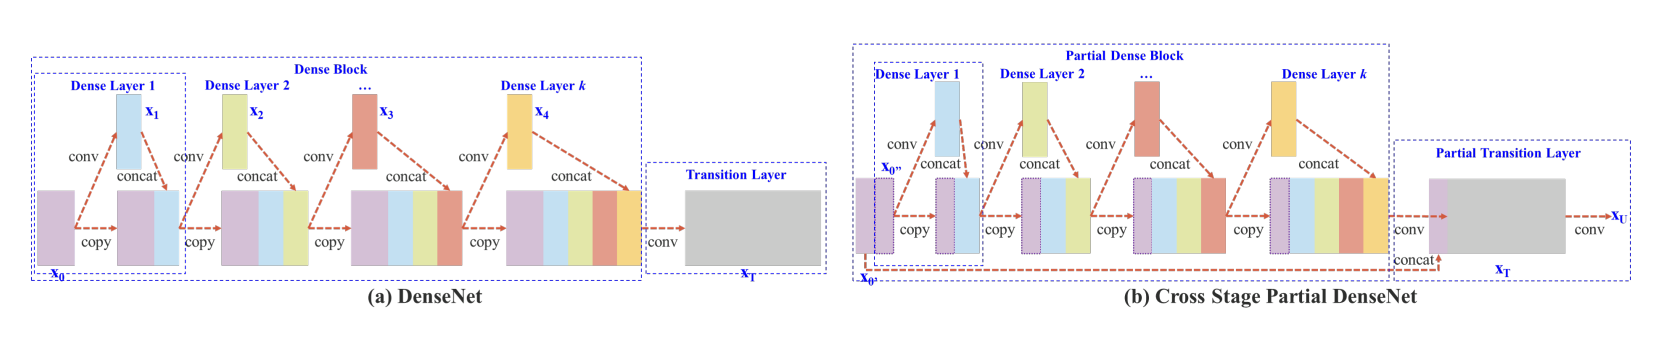

In [1]:
import torch 
import torch.nn as nn

In [2]:
class Transition(nn.Module):
    def __init__(self, in_channels):
        super(Transition, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=(1, 1), stride=1, padding=0),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        )
        
    def forward(self, x):
        return self.layer(x)

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_rep):
        super(DenseBlock, self).__init__()
        self.layers = self.make_layers(in_channels, num_rep)
        
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.concat([x, layer(x)], dim=1)
        return x
    
    
    def make_layers(self, in_channels, num_rep):
        layers = []
        
        for i in range(num_rep):
            layer = nn.Sequential(
                nn.BatchNorm2d(num_features=in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=1, stride=1),
                nn.BatchNorm2d(num_features=128),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1)
            )
            layers.append(layer)
            in_channels += 32
        return layers

In [4]:
class CSPDenseNet(nn.Module):
    def __init__(self, in_channels, numClasses, repeats=[6, 12, 24, 16]):
        super(CSPDenseNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        channels = self.calculate_channels(in_channels=64, repeats=repeats)
        
        self.layer1 = DenseBlock(in_channels=channels[0], num_rep=repeats[0])
        self.transition1 = Transition(in_channels=channels[1])

        self.layer2 = DenseBlock(in_channels=channels[2], num_rep=repeats[1])
        self.transition2 = Transition(in_channels=channels[3])
        
        self.layer3 = DenseBlock(in_channels=channels[4], num_rep=repeats[2])
        self.transition3 = Transition(in_channels=channels[5])
        
        self.layer4 = DenseBlock(in_channels=channels[6], num_rep=repeats[3])
        
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.BatchNorm1d(num_features=channels[7]),
            nn.Linear(channels[7], numClasses)
        )
       
    
    def calculate_channels(self, in_channels, repeats):
        channels = []
        
        for i in range(len(repeats)):
            channels.append(in_channels // 2)
            in_channels += 32 * repeats[i]
            channels.append(in_channels)
            in_channels //= 2
            
        return channels
        
        
    def forward(self, x):
        x = self.layer(x)
        
        x1, x = torch.split(x, x.size(1) // 2, 1)
        
        x = self.layer1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.transition1(x)
        
        x1, x = torch.split(x, x.size(1) // 2, 1) 
        x = self.layer2(x)
        x = torch.cat([x1, x], dim=1)
        x = self.transition2(x)
        
        
        x1, x = torch.split(x, x.size(1) // 2, 1)
        x = self.layer3(x)
        x = torch.cat([x1, x], dim=1)
        x = self.transition3(x)
        
        x1, x = torch.split(x, x.size(1) // 2, 1)
        x = self.layer4(x)
        x = torch.cat([x1, x], dim=1)
        
        x = self.output(x)
        return x

In [5]:
def CSPDenseNet121(in_channels, numClasses, repeats=[6, 12, 24, 16]):
    return CSPDenseNet(in_channels, numClasses, repeats)

def CSPDenseNet169(in_channels, numClasses, repeats=[6, 12, 32, 32]):
    return CSPDenseNet(in_channels, numClasses, repeats)

def CSPDenseNet201(in_channels, numClasses, repeats=[6, 12, 48, 32]):
    return CSPDenseNet(in_channels, numClasses, repeats)

def CSPDenseNet264(in_channels, numClasses, repeats=[6, 12, 64, 48]):
    return CSPDenseNet(in_channels, numClasses, repeats)

In [6]:
model = CSPDenseNet121(in_channels=3, numClasses=1000)
# model = CSPDenseNet169(in_channels=3, numClasses=10)
# model = CSPDenseNet201(in_channels=3, numClasses=10)
# model = CSPDenseNet264(in_channels=3, numClasses=10)

In [7]:
x = torch.randn((3, 3, 224, 224))

In [8]:
model(x).shape

torch.Size([3, 1000])